In [4]:
import numpy as np
from PIL import Image
import matplotlib
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

# Part 3: Finding the Parameters via Backpropagation
In this notebook, we will walk through the full backpropagation algorithm in two ways, line-by-line and in an organized function. The complexity of keeping track of parameters, derivatives and gradients should demonstrate why we need nicely organized platforms. You will probably think of alternative ways of organizing as we go, if you think of something feel free to speak up and mention these for us all to discuss. It may help you choose a platform to use later on and it will help you develop methods for tracking internals.

In [5]:
# a few helper functions
sigmoid = lambda x: 1.0/(1.0000000000001 + np.exp(-x))
relu = lambda x: np.maximum(x, 0.0)
softmax = lambda x: np.exp(x)/np.nansum(np.exp(x), axis=0)
data = np.random.random((784,1))
# derivative of the activation functions
sigmoid_delta = lambda x, sigmoid: sigmoid(x)*(1-sigmoid(x))
relu_delta = lambda x: np.maximum(x+0.0001, 0.0)/np.maximum(x, 0.0001)-0.0001

Here's one way to abstract the layers/parameters for a neural network.

In [6]:
import collections
def get_params(input_pixels=784, n_hidden=[512], output_classes=10, w_scale=0.01, b_scale=0.0, activations=None):
    fc_sizes=[input_pixels]
    fc_sizes.extend(n_hidden if type(n_hidden) == type(list()) else [n_hidden])
    fc_sizes.append(output_classes)
    '''
    # How would you abstract your layers?
    # One option, build a named collection with lists attached to each
    params=collections.namedtuple('params',['weights','biases','activations'])
    params.weights=[w_scale*np.random.randn(y, x) for x, y in zip(fc_sizes[:-1], fc_sizes[1:])]
    params.biases=[b_scale*np.random.randn(y, 1) for y in fc_sizes[1:]]
    params.activations = activations # if activations is not None else [[]]*(len(fc_sizes)-1)
    '''
    # Another option, layer-indexed params list
    # benefit is each layer is an index into the params
    params=[]
    for i in range(len(fc_sizes)-1):
        layer=collections.namedtuple('layer',['weight','bias','activation'])
        layer.weights = w_scale * np.random.randn(fc_sizes[i+1], fc_sizes[i])
        layer.bias  = b_scale * np.random.randn(fc_sizes[i+1], 1)
        layer.activation = activations[i]
        params.append(layer)
    # Other methods could include a dict or collection of layers, where the input and outputs have specific names
    # and each layer object includes the layers that feed into and take output from it (e.g. Caffe)
    return params

activation_fn=relu
delta_activation_fn=relu_delta
params = get_params(n_hidden=512, activations=[activation_fn, None])

Make a forward() pass function that works with this new collections-based parameter structure. Test it on our data, passing the output through softmax before selecting the max index. For random parameters, recall we should expect the softmax "probability" to be 1/N classes = 0.1.

In [8]:
def forward(data, params, forward_only=True):
    activations=[data]
    features=[]
    for layer in params:
        features.append(np.dot(layer.weights, activations[-1]) + layer.bias)
        activations.append(layer.activation(features[-1]) if layer.activation is not None else features[-1])
    if forward_only:
        return activations[-1]
    else:
        return activations,features
    
print('Testing forward with layer-based param structure')
maxind = np.argmax(softmax(forward(data, params)), axis=0)[0]
print('Maximum index: ', maxind)
print('"Probability": ', np.around(softmax(forward(data, params))[maxind][0], decimals=3))

Testing forward with layer-based param structure
Maximum index:  2
"Probability":  0.104


# Brief aside on loss function
The log-likelihood loss function. I've seen this called cross-entropy (posters, papers), some of the platforms call this "softmax cross entropy", which is close enough. 

True cross-entropy loss is difference between label and output distributions as used with sigmoid while log-likelihood is what it looks like with softmax, and softmax is useful for reporting "probabilities" (which they aren't really). Hence, we use softmax+log-likelihood loss for classification here.

In [9]:
# Cross-entropy loss function, log of the softmaxed output at the correct class.
# Goal of training is to increase it (to 1.0) and decrease all others
labels=np.asarray([[8]])
ce_loss = lambda labels,output: -np.nansum(np.log(softmax(output))* one_hot(labels, output.shape[0]), axis=0)
# turn a label into a one-hot vector (0's for non-label, 1 for the label)
one_hot = lambda labels, n_classes: np.eye(n_classes)[np.array(labels).reshape(-1)].transpose()

What might this softmax cross-entropy loss look like in a real training run?
Recall softmax produces outputs that sum to 1.0, they look like probabilities from 0.0 to 1.0.
Realistically, a random network with 10 classes will produce ten outputs about 1/10 = 0.10.

Typical starting softmax cross-entropy loss (p = 0.1):  2.3025850929940455
Decent ending softmax cross-entropy loss (p ~ 0.95 or so):  0.05129329438755058


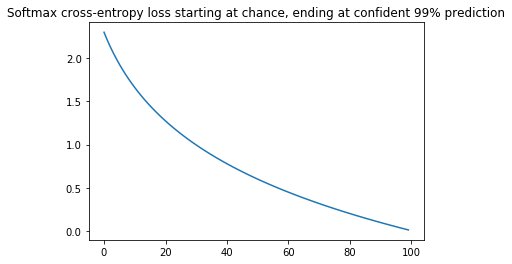

In [10]:
print('Typical starting softmax cross-entropy loss (p = 0.1): ', -np.log(0.1))
print('Decent ending softmax cross-entropy loss (p ~ 0.95 or so): ', -np.log(0.95))
plt.plot(-np.log(np.linspace(0.1,0.99,100)))
plt.title('Softmax cross-entropy loss starting at chance, ending at confident 99% prediction')
plt.show()

Remember the loss is sensitive to two things with the _relative values_ outputted by the network: maximizing the correctly classed example and minimizing the others.
Therefore, it is possible for accuracy and loss to not track each other perfectly. Accuracy
can stop improving while loss continues to decrease, typically meaning the network is becoming more confident than we want.

Another thing to be aware of is these aren't really confidences, and it would be trivial to re-map these relative values to a more meaningful (e.g. more useful) set of confidences in that they more match experience with real world data. 
Its a sort of illusion to consider these as confidences, they only relate to relative scaling. The amount of confidence scaling applied with softmax can be manipulated with the "temperature" parameter. See online for examples.
Also note with softmax cross-entropy, due to the softmax, the loss can continue to decrease while accuracy remains constant because the top-returned class can continue being correct at the same rate while the network learns to become less equivocal overly-certain in its output. A reduction in this kind of loss without an increase in accuracy may mean the network is becoming more brittle

In [ ]:
# Regression loss, L2 and L1
l2_loss = lambda labels,output: -0.5*np.nanmean(np.power(output - labels, 2.0))
l1_loss = lambda labels,output: -np.nanmean(np.abs(output - labels))
# because we nearly always consider loss as a scalar, typically we take the mean above
# however, gradient functions need to remain un-summed
l2_loss_delta = lambda labels,output: -(output - labels)
l1_loss_delta = lambda labels,output: -np.where(output>labels, \
                                         np.ones((len(labels),)), -np.ones((len(labels),)))
# random data with and without outliers
y = np.arange(100)
loss_data = 5*np.random.random((100,))+y
loss_data_outliers = np.copy(loss_data)
inds=[4,8,15]
loss_data_outliers[inds] = 100
print('L1 Losses on clean, corrrupted data: ',[l1_loss(loss_data, y), \
                                               l1_loss(loss_data_outliers, y)])
print('L2 Losses on clean, corrrupted data: ',[l2_loss(loss_data, y), \
                                               l2_loss(loss_data_outliers, y)])
y = y.astype(np.float)
# cross-entropy loss formulated for use in regression
ce_regression_loss = lambda labels, output: -np.nansum(labels * \
                      np.log(sigmoid(output)) + (1 - labels) * np.log(1 - sigmoid(output)))
print('CE Losses on clean, corrrupted data: ' \
      ,[ce_regression_loss(loss_data/100.0, y/100.0), \
        ce_regression_loss(loss_data_outliers/100.0, y/100.0)])

# Backpropagation for FC neurons

To recap, we're working on a network with two layers: $ w1 = [512, 784], b1 = [512,1], w2 = [10,512], b2 = [10,1] $

First (hidden) layer feature map: $$ z^1_j = (w^1_{ij} . x_i) + b^1_j $$

activation of hidden layer map: $$ a^1_j = g(z^1_j) $$

Second (output) layer map: $$ z^2_k = (w^2_{jk} . a^1_j) + b^2_k $$

Final output after softmax: $$ S_k = \frac{exp(z^2_k)}{sum_k(exp(z^2_k))}
                    = \frac{exp([w^2_{jk} * g((w^1_{ij} * x_i) + b_j)] +b^2_k)}{sum_k(exp([w^2_{jk} * g((w_{ij} * x_i) + b_j)] +b^2_k))} $$

Loss is $ -log(S_i) $ and is a scalar, where $i==label$

At each layer we'll be computing and back-propagating $\frac{dL}{dz_{in}}$, where L=loss, $z_{in}$ is the feature map from the previous layer into the layer of interest. Then we'll be using the layer gradient to compute the weights gradient for the weights parameters, as $\frac{dL}{dw_{i}}$.

## Breaking down into components

The gradient of the softmax loss w.r.t. activation coming from penultimate layer
  $$ \frac{dL}{dz} = \frac{dL}{dS} * \frac{dS}{da} * \frac{da}{dz} $$

Gradient w.r.t. weight (S=softmaxed output, a=feature output at layer i, W=weight at layer i):
  $$ \frac{dL}{dw_i} = \frac{dL}{dS} * \frac{dS}{da} * \frac{da}{dz} * \frac{dz}{dw}$$

Gradient w.r.t. bias (b_i is bias at layer i):
  $$ \frac{dL}{db_i} = \frac{dL}{dS} * \frac{dS}{da} * \frac{da}{dz} * \frac{dz}{db} $$

Breaking down the dz for weights and biases gives us:
  $$\frac{dz}{dw} = \frac{d(w * activation_{i-1} + bias}{dw} = activation_{i-1} $$

  $$\frac{dz}{db} = \frac{d(w * activation_{i-1} + bias)}{dbias} = 1 $$

Breaking down the dL for softmax gives:
$$\frac{dL}{dS} = \frac{d(-log(S_i))}{dS} = -\frac{1}{S_i} $$

## Softmax derivative
The softmax derivative has two cases: $y==i$ and $y!=i$

$$ \frac{dS}{da} = S_k - S_k*S_i (k==i) and -S_k*S_i (k!=i)$$
$$ \frac{dS}{da} = S_i - S_i*S_i (k==i) and -S_k*S_i (k!=i)$$
$$ \frac{dS}{da} = S_i*onehot(label) - S_k*S_i$$

where $S_k$ is the full softmaxed output vector and $S_i$ is (a scalar) made up of $S_k$ indexed at the label index. We can combine $\frac{dS}{da}$ and $\frac{dL}{dS}$ as softmax - onehot(label).

## Weight decay
We will also have an additional term in loss for weight decay (for every weight parameter): $$ L_{reg} = wd*0.5*sum(w^2) $$

This second term will be added for each layer's weights gradient term: $$ \frac{dL_{reg}}{dw} = wd*w $$

In [ ]:
ce_softmax_delta = lambda labels,output: output - one_hot(labels, output.shape[0])


To summarize, we can write dL/dw at the second layer more simply:

$$\frac{dL}{dw} = - \frac{1}{S_i} * (S_i*one\_hot(label) - S_k*S_i) * (input\_activation) + wd*w $$
$$ = (S_k - one\_hot(label)) * (input\_activation) + wd*w$$

Next, back-propagate the second layer's gradient to the first layer. Once we have that, we will have everything we need to implement backpropagation for this network.

If we have the gradient at the second layer, we can simply reverse the forward operation and use the second layer's weights (transposed) to back-compute the gradient at the first layer. Note, this isn't quite the first layer gradient, because there was an activation layer between them, so we also have to partial in the activation gradient.

$$dlayer_i = w^T_{i+1} * dlayer_{i+1} * \frac{da_i}{dz_i}$$

## Compute gradients
Finally, we can run a forward pass and get the activations and features for both layers to prepare for gradient computation.

In [ ]:
activations,features = forward(data, params, forward_only=False)
softmax_outputs = softmax(activations[-1])
loss = ce_loss(labels, activations[-1])
print('Single forward pass loss on initialized network: ',loss)

Compute the gradient for the last layer and the parameters associated with it. Notice we don't apply an activation derivative, because the only function applied to the last layer (softmax) has already been accounted for in the ce_softmax_delta() function. Also notice when computing the weights gradient from the layer gradient, the activation that flowed into this layer must be transposed.

In [ ]:
grad_last_layer = ce_softmax_delta(labels, softmax_outputs)

# assign bias grad
grad_last_biases = grad_last_layer
grad_last_weights = np.dot(grad_last_layer, activations[-2].transpose())
# check shape, must match the weights shape
assert grad_last_weights.shape == params[-1].weights.shape, 'gradient and weights shapes do not match'

Get the weight-decay term and sum into the weights gradient. Use an appropriately small weight-decay hyperparameter (0.0005 is common).

In [ ]:
wd=0.0005
l2_last_weights = wd * params[-1].weights
grad_last_weights += l2_last_weights
print('Backprop, grad_last_layer shape: ',grad_last_layer.shape)

Error propagation/backpropagate to the gradient for the next layer back.
 $$\frac{dz_{out}}{dz_{in}} = \frac{dz_{out}}{da_{in}} * \frac{da_{in}}{dz_{in}} $$ 

Or, np.dot(next layer's weights, grad_last_layer above) * $\frac{da_{in}}{dz_{in}}$.

The gradient at a layer back is equal to the gradient at the next layer, backwardly multiplied by the next layer's weights times any partial derivative for anything happening between this layer and the next (e.g. any derivative due to the activation layer and as in the above case, the current layer's input activation). Recall the dot product used forward direction takes the input channels and transforms by inner product sum to get the output channels, so taking the dot of the transpose takes the gradient in the form of the layer's output channels and gets us back to the input channel dimension.

In [ ]:
grad_first_layer = np.dot(params[-1].weights.transpose(), grad_last_layer) * relu_delta(features[-2])

Thus to keep pushing back further, to get the gradient at the previous layer, we first multiply the transpose of the current layer's weights by the current layer's gradient to get the gradient at the activation layer between the previous and current layers. Then multiply by the activation layer gradient to get the gradient at said layer.

In [ ]:
grad_first_biases = grad_first_layer
grad_first_weights = np.dot(grad_first_layer, activations[-3].transpose())
assert grad_first_weights.shape == params[0].weights.shape, 'gradient and weights shapes do not match'

# again get the weight-decay term (assuming we're using weight decay)
l2_first_weights = wd * params[0].weights
grad_first_weights += l2_first_weights
print('Backprop, grad_first_layer shape: ',grad_first_layer.shape)

# A few takeaways
Small activations result in small gradients, and small weights in the next layer will result in small backprop gradients. 

Large activations can blow up if nothing is done to prevent them (e.g. weights regularization, gradient clamping).

When using a clamping activation like relu, if something isn't activated the gradients will also be clamped. 

With most of the other nonlinear activations (e.g. sigmoid, tanh) that squish output nonlinearly, the derivative is very small for either large or small feature values, a condition commonly described as a "saturated" neuron. ReLU solves one end of this, leaky relu or prelu or selu were motivated to solve this issue.

  grad_at_some_layer = np.recursive_dot( (next_layer_weights.T, next_layer_grads) * delta_activation(previous_layer_forward_output) )

  grad_at_some_layer_weights = np.dot(grad_at_some_layer, activations_into_this_layer.T)

This means that the backpropagated gradients grow geometrically in dependence on the subsequent weights and changes in activation as you move back. 

Next look at the gradient at the output we started with, cross-entropy vs L2

  ce_grad_last_layer = (softmax(outputs) - one_hot(labels, outputs.shape[0]))

  l2_grad_last_layer = (outputs - labels) * sigmoid_delta()

Unfortunately, the sigmoid_delta can become 0 or 1 easily, and at that point, sigmoid_delta(close to 0 or close to 1) = 0, and the output gradient we want to start with becomes zero easily. Softmax cross-entropy does not have this issue. We can avoid this by avoiding a sigmoid on the output, but this results in an unconstrained output (can be handled in other ways)

# Backpropagation functionalized

In [ ]:
def forward_hybrid_onesample(data, label, params, loss_fn, loss_fn_delta, activation, activation_delta, wd=0.0005):
    # activations (input to the next layer, equal to feature when no activation used)
    a_l = [data]
    # feature maps
    f_l = []
    delta_a_l = []
    # compute the forward calculations and store the features and activations and the derivative of the parameters at these values
    for layer in params:
        # append feature and activation outputs
        f_l.append(np.dot(layer.weights, a_l[-1]) + layer.bias)
        # calc activation if specified, else just the raw feature map
        a_l.append(layer.activation(f_l[-1]) if layer.activation is not None else f_l[-1])
        # same for gradient, else just ones
        delta_a_l.append(activation_delta(f_l[-1]) if layer.activation is not None else f_l[-1]/f_l[-1])

    loss = loss_fn(label, a_l[-1])
    # gradient at the loss
    layerback = 1
    # gradient at the last layer is the cost gradient times the derivative of the last activation layer
    # in our toy network, we did no activation on last layer...
    gradient_layer = loss_fn_delta(label, a_l[-1]) * delta_a_l[-1]
    # gradients (in reverse order)
    grad_w_reverse=[]
    grad_b_reverse=[]
    # store the gradients, bias is simply the gradient we compute above at this layer
    grad_b_reverse.append(gradient_layer)
    # weights gradient is this layer's gradient dotted with the previous layer's activation output (e.g. what this layer saw as input)
    grad_w_reverse.append(np.dot(gradient_layer, a_l[-2].transpose()) + wd * params[-1].weights)

    # backward further, subsequent layers depend on the following layer's activation_delta
    N_layers = len(params)
    for layerback in range(1, N_layers):
        current_layer=N_layers - layerback
        previous_layer=current_layer - 1
        gradient_layer = np.dot(params[current_layer].weights.transpose(), gradient_layer) * delta_a_l[previous_layer]
        # backpropagation: gradient at a given layer is equal to the next layer's weights dotted with the next layer's gradient
        # then the bias' gradient is said gradient, and weights' gradient is said gradient dotted with the activations that were inputted to this layer
        grad_b_reverse.append(gradient_layer)
        grad_w_reverse.append(np.dot(gradient_layer, a_l[previous_layer].transpose()) + wd * params[previous_layer].weights)
    return (grad_w_reverse, grad_b_reverse, loss, a_l[-1])

In [ ]:
# get params for a one-hidden layer network with 64 units
activation_fn=relu
delta_activation_fn=relu_delta
params = get_params(n_hidden=[64], activations=[activation_fn, None])
# grab gradients for a single made-up example
gradw_r,gradb_r,loss,output = forward_hybrid_onesample(data, labels, params, ce_loss, ce_softmax_delta, activation_fn, delta_activation_fn)
print('Single pass thru initialized network, loss = ',loss)

About what we'd expect, the loss when all outputs are at chance should be log(0.1).

# Check gradients numerically
Modern platforms include things like auto-differentiation and numeric checks in their CI/automated tests, so you may only need to do this if you make new layers or check a new loss function for stability. The result should be on the order of the epsilon used (0.0001 here).

In [ ]:
import copy
eps=0.0001
dgwp=[]
dgbp=[]
for i in range(784):
    datap=copy.deepcopy(data)
    datan=copy.deepcopy(data)
    datap[i] += eps
    datan[i] -= eps
    gwp,gbp,lp,op =  forward_hybrid_onesample(datap, labels, params, ce_loss, ce_softmax_delta, relu, relu_delta)
    gwn,gbn,ln,on =  forward_hybrid_onesample(datan, labels, params, ce_loss, ce_softmax_delta, relu, relu_delta)
    dgwp.append(sum([np.nansum(p-n) for p,n in zip(gwp,gwn)])/(2*eps*sum([np.prod(p.shape) for p in gwp])))
    dgbp.append(sum([np.nansum(p-n) for p,n in zip(gbp,gbn)])/(2*eps*sum([np.prod(p.shape) for p in gbp])))
dgwp=np.asarray(dgwp)
dgbp=np.asarray(dgbp)
print([np.prod(p.shape) for p in gbp])
print([np.prod(p.shape) for p in gwp])
plt.plot(dgbp)
plt.title('bias gradient numeric check')
plt.show()
plt.plot(dgwp)
plt.title('weights gradient numeric check')
plt.show()
print('min, max, mean weights delta',[np.min(dgwp), np.max(dgwp), np.nanstd(dgwp)])
print('min, max, mean biases delta',[np.min(dgbp), np.max(dgbp), np.nanstd(dgbp)])

# Data loader for MNIST
Dead-simple, no bells and whistles beyond shuffling (randomizing the order of data samples). 

In [ ]:
import gzip
import struct
datasets=['data/train-labels-idx1-ubyte.gz', 'data/train-images-idx3-ubyte.gz']
with gzip.open(datasets[0], 'rb') as fp:
    # labels
    magic=struct.unpack(">L", fp.read(size=4))[0]
    assert magic == 2049, 'magic number in header does not match expectations'
    num_items=struct.unpack(">L", fp.read(size=4))[0]
    mnist_labels=np.asarray(list(fp.read()))

with gzip.open(datasets[1], 'rb') as fp:
    magic=struct.unpack(">L", fp.read(size=4))[0]
    assert magic == 2051, 'magic number in header does not match expectations'
    num_imgs=struct.unpack(">L", fp.read(size=4))[0]
    num_rows=struct.unpack(">L", fp.read(size=4))[0]
    num_cols=struct.unpack(">L", fp.read(size=4))[0]
    data=np.asarray(list(fp.read()))
    mnist_data=data.reshape((num_imgs, 28, 28, 1))
    
# randomize index and get data loader
index=np.arange(num_items)
np.random.shuffle(index)
data_loader = zip([d for d in mnist_data[index,:,:,:]], [l for l in mnist_labels[index]])
# not really a normalization just a rescaling to 0-1
normalize_image = lambda img: (img-np.nanmin(img))/(np.nanmax(img)-np.nanmin(img)) if np.nanmax(img) > 0.0 else img
print('created one-time use simple data_loader with n_images = ', num_imgs)

# Training loop
Make a training loop and update the parameters with stochastic gradient descent. Display the first 5 data examples as images and 

In [ ]:
batch_size=64
batch_index=0
wgrads_mov_avg=None
# SGD with momentum
update_mov_avg = lambda grads, batch_size, grads_mov_avg, momentum: [momentum * m + (1-momentum)*g/batch_size for g,m in zip(grads, grads_mov_avg)]
loss_mov_avg = 0.0
lr=0.1
acc=[]
grad_w_r_acc=None
params_copy = copy.deepcopy(params)
momentum=0.9
for batchnum,batch in enumerate(data_loader):
    img,lbl= batch
    img=img.reshape((784,1)).astype(np.float32)
    nimg=normalize_image(img)
    gradw_r,gradb_r,loss,output = forward_hybrid_onesample(nimg, lbl, params_copy, ce_loss, ce_softmax_delta, activation_fn, delta_activation_fn)
    loss_mov_avg += loss
    maxind = np.argmax(softmax(output), axis=0)[0]
    acc.append(maxind==lbl)
    # initialize the batch gradient accumulator, will be re-set after each batch_size
    if grad_w_r_acc is None:
        gradw_r_acc = gradw_r
        gradb_r_acc = gradb_r
    else:
        gradw_r_acc = [g1+g2 for g1,g2 in zip(gradw_r_acc, gradw_r)]
        gradb_r_acc = [g1+g2 for g1,g2 in zip(gradb_r_acc, gradb_r)]
    batch_index +=1
    if batch_index==batch_size:
        # accumulate a batch into the gradient tracker (SGD)
        # recall the accumulator must be divided by batch_size as it is simply a sum over the batch
        if wgrads_mov_avg is None:
            wgrads_mov_avg = [w/batch_size for w in gradw_r_acc]
            bgrads_mov_avg = [b/batch_size for b in gradb_r_acc]
        else:
            wgrads_mov_avg = update_mov_avg(gradw_r_acc, batch_size, wgrads_mov_avg, momentum)
            bgrads_mov_avg = update_mov_avg(gradb_r_acc, batch_size, bgrads_mov_avg, momentum)
        # Update parameters with SGD (learning_rate times the momentum-moving-averaged gradient)
        for j in range(len(params_copy)):
            params_copy[j].weights -= lr*wgrads_mov_avg[-j-1]
            params_copy[j].bias    -= lr*bgrads_mov_avg[-j-1]
        # reset the batch gradient accumulator
        gradw_r_acc=None
        batch_index = 0
    if batchnum % (batch_size*100) == 1:
        print('Batch %d, Loss avg: %.02f, acc: %.2f'%(int(batchnum/batch_size), loss_mov_avg/batchnum, sum(acc)/len(acc)))
        if batchnum>batch_size*400:
            break
    # inspect the first few
    if batchnum>=5:
        continue
    print('output: ', output)
    plt.imshow(img.reshape((28,28)))
    plt.title(lbl)
    plt.show()
print('Ran one Epoch')

# save parameters to a dill file
import dill
with open('nnet_params_oneepoch.dill','wb') as fp:
    listparams=[[p.weights,p.bias] for p in params_copy]
    dill.dump(listparams, fp)

# Train multiple epochs

Perform N epochs of training, re-shuffling training data each time. You should see the loss gradually decrease and accuracy increase from a baseline of 0.1. Note if a moving average for some value (e.g. loss) gets reset on each epoch, you'll see it increase for the first batch, which you can ignore for now. How would you improve that?

Many hyperparameters you can play with, from learning rate schedules, batch sizes, early stopping, weight decay and so forth.

In [ ]:
epochs=20
reduction_epochs=[10, 15, 18]
#activation_fn=sigmoid
#delta_activation_fn=sigmoid_delta
#params = get_params(n_hidden=[512, 256], activations=[activation_fn, activation_fn, None])
params = get_params(n_hidden=[64], activations=[activation_fn, None])
# accuracy accumulator
acc_acc = []
grad_w_r_acc=None
wgrads_mov_avg=None
for epoch in range(epochs):
  if epoch in reduction_epochs:
      lr=lr/1.5
  batch_index=0
  acc=[]
  loss_mov_avg = 0.0
  # randomize index and get data loader
  index=np.arange(num_items)
  np.random.shuffle(index)
  data_loader = zip([d for d in mnist_data[index,:,:,:]], [l for l in mnist_labels[index]])
  grad_w_r_acc=None
  wgrads_mov_avg=None
  # main training loop
  for batchnum,batch in enumerate(data_loader):
    img,lbl= batch
    img=img.reshape((784,1)).astype(np.float32)
    nimg=normalize_image(img)
    randnoise=np.random.randn(784).reshape((784,1))*0.025
    nimg=nimg+randnoise
    # what would happen if we modified the image here before passing to forward, how would that affect the network's ability to learn?
    # try adding some random noise...
    gradw_r,gradb_r,loss,output = forward_hybrid_onesample(nimg, lbl, params, ce_loss, ce_softmax_delta, activation_fn, delta_activation_fn)
    loss_mov_avg += loss
    maxind = np.argmax(softmax(output), axis=0)[0]
    maxind = np.argmax(softmax(output), axis=0)[0]
    acc.append(maxind==lbl)
    # initialize the gradient accumulators
    if grad_w_r_acc is None:
        gradw_r_acc = gradw_r
        gradb_r_acc = gradb_r
    else:
        gradw_r_acc = [g1+g2 for g1,g2 in zip(gradw_r_acc, gradw_r)]
        gradb_r_acc = [g1+g2 for g1,g2 in zip(gradb_r_acc, gradb_r)]
    batch_index +=1
    if batch_index==batch_size:
        # initialize the moving-average gradient tracker for SGD
        # recall, accumulator needs to be divided by batch_size so be careful using it blindly
        if wgrads_mov_avg is None:
            wgrads_mov_avg = [w/batch_size for w in gradw_r_acc]
            bgrads_mov_avg = [b/batch_size for b in gradb_r_acc]
        else:
            wgrads_mov_avg = update_mov_avg(gradw_r_acc, batch_size, wgrads_mov_avg, momentum)
            bgrads_mov_avg = update_mov_avg(gradb_r_acc, batch_size, bgrads_mov_avg, momentum)
        for j in range(len(params)):
            params[j].weights -= lr*wgrads_mov_avg[-j-1]
            params[j].bias    -= lr*bgrads_mov_avg[-j-1]
        gradw_r_acc=None
        batch_index = 0
    if batchnum % (batch_size*100) == 1:
        print(' Batch %d, Loss avg: %.02f, acc: %.2f'%(int(batchnum/batch_size), loss_mov_avg/batchnum, sum(acc)/len(acc)))
    # Note, we'll miss the last partial batch - can you think of a simple way to make use of these last images?
    # many ways to do it, see if you can do it in as little as two lines moved above

  acc_acc.append(sum(acc)/len(acc))
  print('Epoch %d, Loss avg: %.02f, acc: %.2f'%(epoch, loss_mov_avg/batchnum, acc_acc[-1]))

import dill
with open('nnet_params.dill','wb') as fp:
    listparams=[[p.weights,p.bias] for p in params]
    dill.dump(listparams, fp)